<a href="https://colab.research.google.com/github/Nunuy15/Thesis/blob/main/HyperTuning_Aug_MobileNetV3_Dasar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Tahap 1: Inisialisasi Generator Gambar**
Pada tahap ini, kita membuat ImageDataGenerator dan mengatur fungsi preprocessing agar sesuai dengan MobileNetV3.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan ImageDataGenerator dengan fungsi preprocessing MobileNetV3
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

# **Tahap 2: Memuat Gambar dari Direktori**
Pada tahap ini, kita membuat generator gambar (train_generator) untuk menghasilkan gambar dari direktori training. Gambar-gambar ini akan diproses sesuai target size yang ditentukan.

In [4]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.2 MB/s eta 0:00:00


# **Tahap 3: Fungsi untuk Menampilkan Gambar dari Setiap Kelas**
Pada tahap ini, kita membuat fungsi untuk menampilkan satu gambar acak dari setiap kelas dalam batch pertama yang dihasilkan oleh generator.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images_from_each_class(generator, class_names, img_height=224, img_width=224):
    """
    Fungsi untuk menampilkan gambar acak dari setiap kelas dalam generator gambar.

    Parameters:
    - generator: ImageDataGenerator yang telah dikonfigurasi
    - class_names: Daftar nama kelas
    - img_height, img_width: Dimensi gambar
    """
    # Menyimpan gambar acak dari setiap kelas
    random_images = {}

    # Mengambil batch pertama dari generator
    for images, labels in generator:
        for i in range(len(images)):
            label = np.argmax(labels[i])  # Mengambil indeks kelas
            class_name = class_names[label]

            # Simpan satu gambar dari setiap kelas
            if class_name not in random_images:
                random_images[class_name] = images[i]

        # Jika sudah memiliki satu gambar dari setiap kelas, hentikan loop
        if len(random_images) == len(class_names):
            break

    # Visualisasi gambar acak dari setiap kelas
    plt.figure(figsize=(15, 8))
    for i, (class_name, image) in enumerate(random_images.items()):
        ax = plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
    plt.show()

# **Tahap 4: Menjalankan Fungsi dan Menampilkan Hasil**
Pada tahap ini, kita menjalankan fungsi yang telah dibuat untuk menampilkan gambar dari setiap kelas. Kita juga mengambil nama kelas dari train_generator untuk memastikan bahwa setiap kelas tercakup.

In [ ]:
# Mendapatkan nama kelas dari train_generator
class_names = list(train_generator.class_indices.keys())

# Tampilkan gambar acak dari setiap kelas
show_random_images_from_each_class(train_generator, class_names)

NameError: name 'train_generator' is not defined

# **Tahap 5: Pembuatan Model**
Pada tahap ini, kita membangun model menggunakan MobileNetV3 sebagai base model, menambahkan beberapa layer tambahan untuk menyesuaikan output dengan jumlah kelas yang diinginkan.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Directories
train_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_PHOTOMETRIC/train'
val_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_PHOTOMETRIC/valid'
test_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_PHOTOMETRIC/test'

# Ukuran gambar dan batch size
img_height, img_width = 224, 224
batch_size = 32

# ImageDataGenerator di luar fungsi build_model
datagen = ImageDataGenerator()

# DataFrame untuk menyimpan hasil tuning
results = pd.DataFrame(columns=['units', 'dropout_rate', 'learning_rate', 'batch_size',
                                'train_accuracy', 'train_loss',
                                'val_accuracy', 'val_loss',
                                'test_accuracy', 'test_loss'])

# Fungsi untuk membuat model tanpa batch size sebagai hyperparameter
def build_model(hp):
    base_model = MobileNetV3Small(
        input_shape=(img_height, img_width, 3),
        alpha=1.0,
        minimalistic=False,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Tune the number of units in dense layer
    units = hp.Int('units', min_value=64, max_value=512, step=64)
    x = Dense(units, activation='relu')(x)

    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    x = Dense(6, activation='softmax')(x)  # 6 adalah jumlah kelas dalam dataset

    # Compile model with a tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperband tuner untuk tuning hyperparameter tanpa batch size
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='mobilenetv3small_tuning'
)

# Callback early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Data generator untuk training, validation, dan test dengan batch size tetap 32
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Tahap pertama: Tuning model hyperparameters
tuner.search(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stop])

# Mendapatkan hyperparameters terbaik dari tuning pertama
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Membuat model dengan hyperparameter terbaik dari tuning
model = tuner.hypermodel.build(best_hps)

# Train model terbaik
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stop])

# Evaluasi pada training, validation, dan test set
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

# Menyimpan hasil ke dalam DataFrame menggunakan pd.concat
new_row = pd.DataFrame([{
    'units': best_hps.get('units'),
    'dropout_rate': best_hps.get('dropout_rate'),
    'learning_rate': best_hps.get('learning_rate'),
    'batch_size': batch_size,
    'train_accuracy': train_accuracy,
    'train_loss': train_loss,
    'val_accuracy': val_accuracy,
    'val_loss': val_loss,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss
}])

# Menggabungkan new_row ke dalam results
results = pd.concat([results, new_row], ignore_index=True)

# Tampilkan tabel hasil
print(results)


Trial 30 Complete [00h 08m 18s]
val_accuracy: 0.8130719065666199

Best val_accuracy So Far: 0.8839869499206543
Total elapsed time: 05h 20m 47s
Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - accuracy: 0.6427 - loss: 0.9072 - val_accuracy: 0.7739 - val_loss: 0.6019
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 48s 140ms/step - accuracy: 0.8254 - loss: 0.4656 - val_accuracy: 0.8085 - val_loss: 0.5188
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 49s 143ms/step - accuracy: 0.8575 - loss: 0.3731 - val_accuracy: 0.8206 - val_loss: 0.4626
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step - accuracy: 0.8927 - loss: 0.2947 - val_accuracy: 0.8337 - val_loss: 0.4362
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 48s 140ms/step - accuracy: 0.9042 - loss: 0.2565 - val_accuracy: 0.8500 - val_loss: 0.4224
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 48s 142ms/step - accuracy: 0.9279 - loss: 0.1976 - val_accuracy: 0.8444 - val_loss: 0.4382
Epoch 7/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 48s 142ms/step - accuracy: 0.94

<ipython-input-1-17cae621cd4e>:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


In [2]:
results.to_csv('hyperparameter_tuning_results.csv', index=False)

print(results)



  units  dropout_rate  learning_rate batch_size  train_accuracy  train_loss  \
0   512           0.2          0.001         32        0.980205    0.081914   

   val_accuracy  val_loss  test_accuracy  test_loss  
0       0.86732   0.37815       0.906536   0.296517  


In [3]:
results

,units,dropout_rate,learning_rate,batch_size,train_accuracy,train_loss,val_accuracy,val_loss,test_accuracy,test_loss
0,512,0.2,0.001,32,0.980205,0.081914,0.86732,0.37815,0.906536,0.296517


Test Loss: 0.2965174615383148
Test Accuracy: 0.9065359234809875
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step
                precision    recall  f1-score   support

        kosong       0.99      0.99      0.99       255
 kurang_matang       0.82      0.85      0.83       255
        matang       0.85      0.91      0.88       255
        mentah       0.92      0.89      0.90       255
terlalu_matang       0.97      0.93      0.95       255
  tidak_normal       0.90      0.87      0.89       255

      accuracy                           0.91      1530
     macro avg       0.91      0.91      0.91      1530
  weighted avg       0.91      0.91      0.91      1530



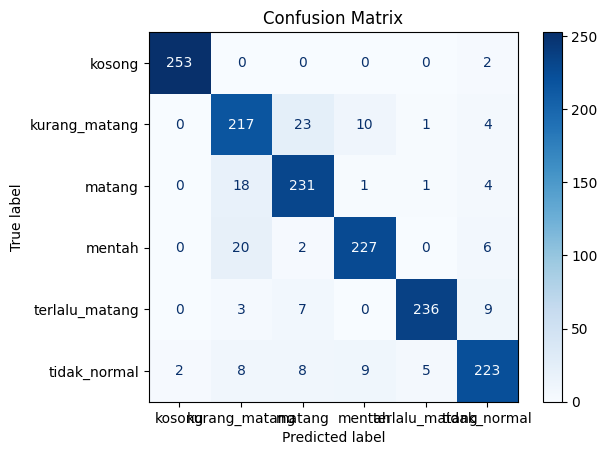

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluasi model terbaik pada data uji
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Prediksi label pada data uji
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Laporan klasifikasi
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


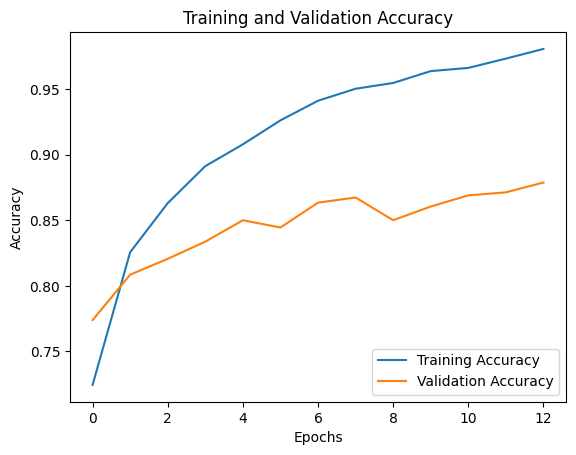

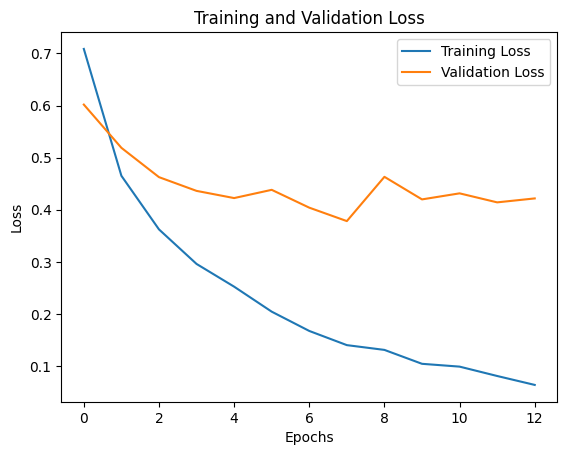

In [5]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


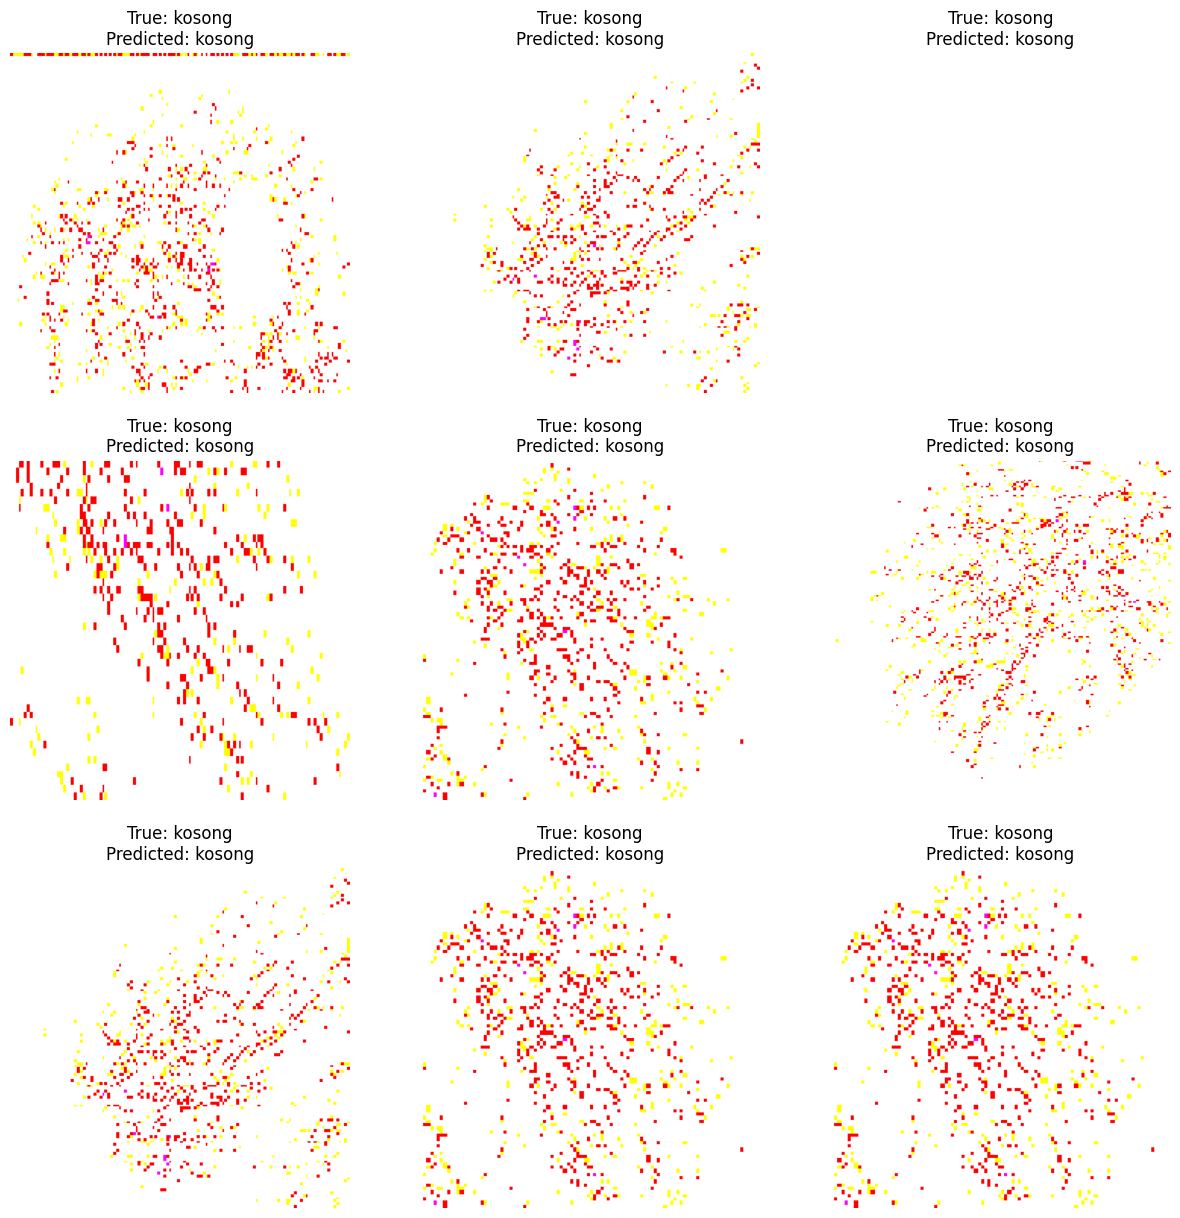

In [6]:
# Visualisasi beberapa prediksi pertama
import random

# Mengambil batch gambar dari test generator
test_images, test_labels = next(test_generator)
test_predictions = model.predict(test_images)
predicted_classes = np.argmax(test_predictions, axis=1)

plt.figure(figsize=(15, 15))
for i in range(9):
    index = random.randint(0, len(test_images) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[index])
    true_label = class_labels[np.argmax(test_labels[index])]
    predicted_label = class_labels[predicted_classes[index]]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')
plt.show()


NameError: name 'precision' is not defined

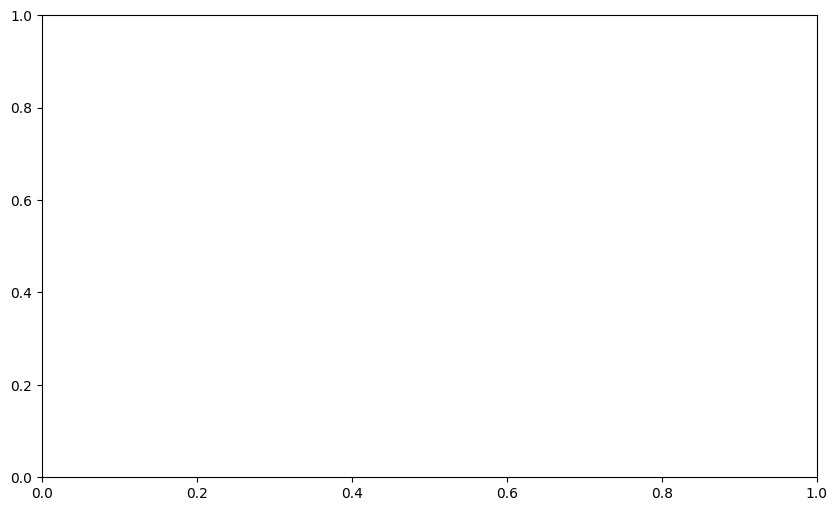

In [7]:
# Visualisasi Precision, Recall, dan F1 Score per kelas
x = np.arange(len(class_labels))  # label kelas sebagai posisi sumbu X
width = 0.25  # lebar batang

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Menambahkan teks label pada masing-masing batang
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()

# Menampilkan nilai di atas masing-masing batang
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # format angka dengan dua desimal
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # sedikit offset untuk menempatkan angka di atas batang
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()

# **Tahap 6: Melatih Model**
Melatih model menggunakan generator data yang telah dikonfigurasi sebelumnya, yaitu `train_generator` dan `val_generator`.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Menambahkan Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metrik yang dipantau
    patience=5,            # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik setelah berhenti
)

# Training model dengan Early Stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


893/893 ━━━━━━━━━━━━━━━━━━━━ 7863s 9s/step - accuracy: 0.5053 - loss: 1.2654 - val_accuracy: 0.6912 - val_loss: 0.8036
Epoch 2/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 121s 135ms/step - accuracy: 0.7301 - loss: 0.7261 - val_accuracy: 0.7148 - val_loss: 0.7250
Epoch 3/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 121s 135ms/step - accuracy: 0.7672 - loss: 0.6231 - val_accuracy: 0.7540 - val_loss: 0.6521
Epoch 4/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 121s 134ms/step - accuracy: 0.7886 - loss: 0.5717 - val_accuracy: 0.7614 - val_loss: 0.6317
Epoch 5/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 119s 132ms/step - accuracy: 0.8070 - loss: 0.5274 - val_accuracy: 0.7702 - val_loss: 0.6085
Epoch 6/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 119s 132ms/step - accuracy: 0.8153 - loss: 0.5014 - val_accuracy: 0.7821 - val_loss: 0.5818
Epoch 7/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 120s 133ms/step - accuracy: 0.8201 - loss: 0.4808 - val_accuracy: 0.7810 - val_loss: 0.5786
Epoch 8/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 120s 134ms/step - accuracy: 0.8288 - loss: 0.4582

# **Tahap 7: Evaluasi Model**
Melakukan evaluasi pada data test dan menghasilkan laporan klasifikasi serta confusion matrix untuk mengetahui performa model pada data yang belum pernah dilihat.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Prediksi pada data test
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Laporan klasifikasi
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 990s 8s/step
                precision    recall  f1-score      support
kosong           0.941435  0.945588  0.943507   680.000000
kurang_matang    0.773256  0.782353  0.777778   680.000000
matang           0.838617  0.855882  0.847162   680.000000
mentah           0.892424  0.866176  0.879104   680.000000
terlalu_matang   0.917160  0.911765  0.914454   680.000000
tidak_normal     0.840943  0.839706  0.840324   680.000000
accuracy         0.866912  0.866912  0.866912     0.866912
macro avg        0.867306  0.866912  0.867055  4080.000000
weighted avg     0.867306  0.866912  0.867055  4080.000000


In [ ]:
# Evaluasi akurasi pada data testing
test_loss, test_accuracy = model.evaluate(test_generator)

print("Testing Accuracy:", test_accuracy)

128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.8841 - loss: 0.2939
Testing Accuracy: 0.866911768913269


# **Tahap 8: Visualisasi Hasil Training dan Evaluasi**

# 8.1. Visualisasi Akurasi Training dan Validation
Menampilkan grafik akurasi training dan validation dari hasil pelatihan untuk memantau kinerja model.

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


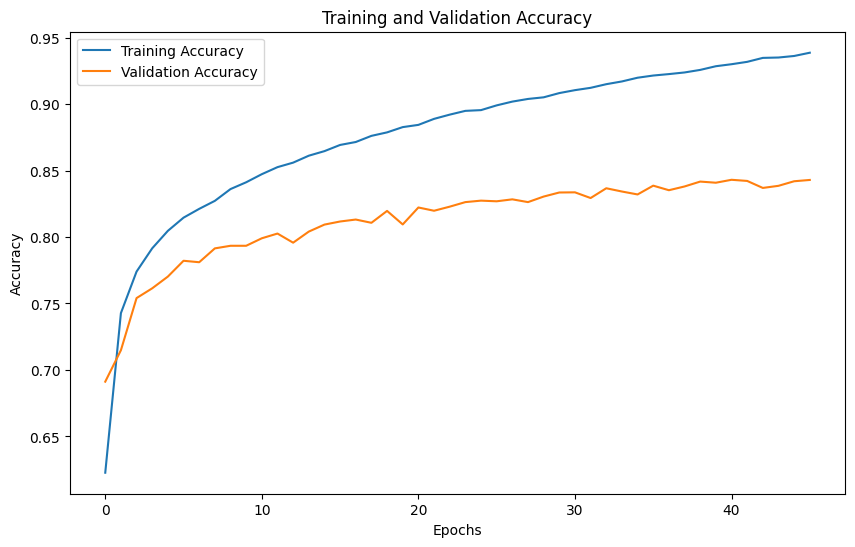

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# 8.2. Visualisasi Precision, Recall, dan F1 Score per Kelas
Menampilkan precision, recall, dan f1-score untuk setiap kelas.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Prediksi pada data uji
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Laporan klasifikasi dengan precision, recall, dan f1-score per kelas
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Ambil metrik precision, recall, dan f1-score per kelas saja
df_metrics = report_df.loc[class_labels, ["precision", "recall", "f1-score"]]

# Plot Precision, Recall, dan F1 Score per kelas
df_metrics.plot(kind="bar", figsize=(10, 6))
plt.title("Precision, Recall, and F1 Score by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.xticks(rotation=45)
plt.show()


# 8.3. Visualisasi Confusion Matrix
Menampilkan confusion matrix untuk memeriksa kesalahan klasifikasi model pada data test.

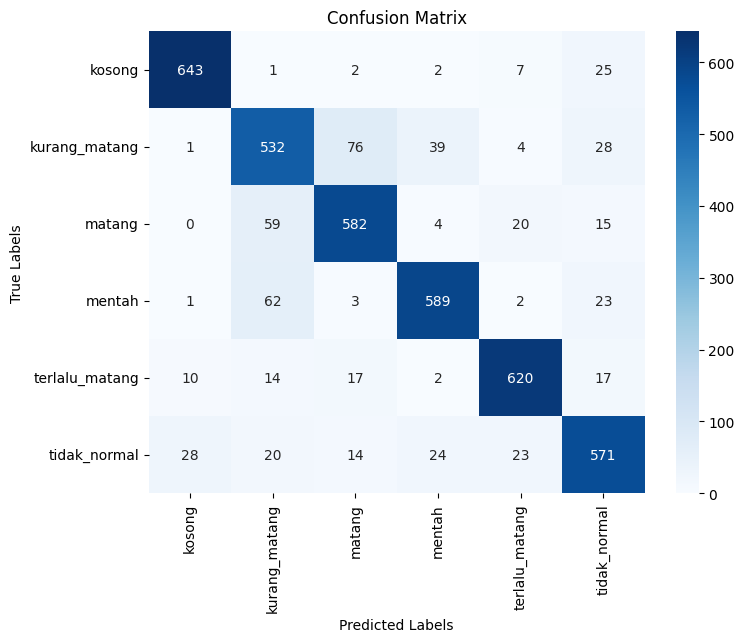

In [ ]:
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Tahap 9: Menyimpan Model**
Simpan model yang telah dilatih untuk digunakan di masa mendatang.

In [ ]:
# Menyimpan model
model.save('/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/saved_model_mobileNetV3Large_tunner.keras')

In [ ]:
# Menghitung rata-rata akurasi dan loss untuk Training dan Validation
training_accuracies = history.history['accuracy']
training_losses = history.history['loss']
validation_accuracies = history.history['val_accuracy']
validation_losses = history.history['val_loss']

avg_training_accuracy = sum(training_accuracies) / len(training_accuracies)
avg_training_loss = sum(training_losses) / len(training_losses)
avg_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)
avg_validation_loss = sum(validation_losses) / len(validation_losses)

print("Rata-rata Training Accuracy:", avg_training_accuracy)
print("Rata-rata Training Loss:", avg_training_loss)
print("Rata-rata Validation Accuracy:", avg_validation_accuracy)
print("Rata-rata Validation Loss:", avg_validation_loss)

# Evaluasi rata-rata pada data Testing
test_loss, test_accuracy = model.evaluate(test_generator)
print("Testing Accuracy:", test_accuracy)
print("Testing Loss:", test_loss)


Rata-rata Training Accuracy: 0.8763130255367445
Rata-rata Training Loss: 0.3452075836451157
Rata-rata Validation Accuracy: 0.8125399662100751
Rata-rata Validation Loss: 0.5046916720659836
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.8841 - loss: 0.2939
Testing Accuracy: 0.866911768913269
Testing Loss: 0.372585266828537
